# Credit Default Risk Logistic Regression Model

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

from collinearity import SelectNonCollinear
from sklearn.feature_selection import f_classif

from sklearn import set_config
set_config(transform_output='pandas')

In [2]:
# Function to check metrics

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, ConfusionMatrixDisplay

def eval_classification(model, X_train, y_train, X_test, y_test, model_name = 'model', results_frame = None, pos_label=1, average='binary', roc_auc_avg = 'macro'):

  model.fit(X_train, y_train)
  train_pred = model.predict(X_train)
  test_pred = model.predict(X_test)

  if y_train.nunique() > 2 and average == 'binary':
    average = 'macro'

  print('Train Evaluation')
  print(classification_report(y_train, train_pred))
  ConfusionMatrixDisplay.from_predictions(y_train, train_pred, normalize='true', cmap='Blues')
  plt.show()

  print('Test Evaluation')
  print(classification_report(y_test, test_pred))
  ConfusionMatrixDisplay.from_predictions(y_test, test_pred, normalize='true', cmap='Greens')
  plt.show()

  results = pd.DataFrame(index=[model_name])
  results['train_acc'] = accuracy_score(y_train, train_pred)
  results['test_acc'] = accuracy_score(y_test, test_pred)
  results['train_prec'] = precision_score(y_train, train_pred, pos_label=pos_label, average=average)
  results['test_prec'] = precision_score(y_test, test_pred, pos_label=pos_label, average=average)
  results['train_recall'] = recall_score(y_train, train_pred, pos_label=pos_label, average=average)
  results['test_recall'] = recall_score(y_test, test_pred, pos_label=pos_label, average=average)
  results['train_f1'] = f1_score(y_train, train_pred, pos_label=pos_label, average=average)
  results['test_f1'] = f1_score(y_test, test_pred, pos_label=pos_label, average=average)
  results['train_auc'] = roc_auc_score(y_train, model.predict_proba(X_train)[:,1], average=roc_auc_avg, multi_class='ovr')
  results['test_auc'] = roc_auc_score(y_test, model.predict_proba(X_test)[:,1], average=roc_auc_avg, multi_class='ovr')

  if results_frame is not None:
    results = pd.concat([results_frame, results])

  return results

### Preprocessing

In [3]:
# Load filtered train app cleaned in EDA

df = pd.read_csv('Data/Filtered_Train_App.csv')
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START_x,HOUR_APPR_PROCESS_START_x,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_ANNUITY,EXT_SOURCE_2,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,MOST_RECENT,DAYS_CREDIT_REC,MONTHS_BALANCE,STATUS,SK_ID_PREV,PREV_NAME_CONTRACT_TYPE,AMT_APPLICATION,WEEKDAY_APPR_PROCESS_START_y,HOUR_APPR_PROCESS_START_y,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PREV_APP_COUNT,PREV_APP_BINS
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24700.5,0.262949,6158903.0,Active,currency 1,-1042.0,0.0,0.0,0.0,Consumer credit,-7.0,101-125,-103.0,-19.0,C,1038818.0,Consumer loans,179055.0,SATURDAY,9.0,Y,1.0,XAP,Approved,-606.0,XNA,XAP,New,Vehicles,POS,XNA,Stone,500.0,Auto technology,low_normal,1.0,0-10
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,1,1,MONDAY,11,0,0,0,0,0,0,School,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35698.5,0.622246,5885880.0,Active,currency 1,-606.0,0.0,0.0,0.0,Credit card,-43.0,More than 250,-606.0,NaN,NaN,1810518.0,Cash loans,900000.0,FRIDAY,12.0,Y,1.0,XNA,Approved,-746.0,XNA,XAP,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1.0,XNA,low_normal,3.0,0-10
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,1,1,1,1,1,0,2,2,MONDAY,9,0,0,0,0,0,0,Government,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6750.0,0.555912,6829134.0,Closed,currency 1,-408.0,0.0,0.0,0.0,Consumer credit,-382.0,More than 250,-408.0,NaN,NaN,1564014.0,Consumer loans,24282.0,FRIDAY,5.0,Y,1.0,XAP,Approved,-815.0,Cash through the bank,XAP,New,Mobile,POS,XNA,Regional / Local,30.0,Connectivity,middle,1.0,0-10
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,1,1,0,1,0,0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29686.5,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2078043.0,Cash loans,675000.0,THURSDAY,15.0,Y,1.0,XNA,Approved,-181.0,Cash through the bank,XAP,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1.0,XNA,low_normal,9.0,0-10
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,1,1,0,1,0,0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,21865.5,0.322738,5987200.0,Closed,currency 1,-1149.0,0.0,0.0,0.0,Consumer credit,-783.0,More t

In [4]:
# Train Val Split

X = df.drop(columns=['TARGET', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START_x', 'WEEKDAY_APPR_PROCESS_START_y', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'HOUR_APPR_PROCESS_START_y', 'HOUR_APPR_PROCESS_START_x'])
y = df['TARGET'].copy()

# Test data is already provided as separate CSV. Only doing one split of test/val

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")

Train set size: (246008, 83)
Validation set size: (61503, 83)


In [5]:
# Take a quick look at info to make sure columns pass the eye test

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 246008 entries, 123473 to 121958
Data columns (total 83 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   NAME_CONTRACT_TYPE           246008 non-null  object 
 1   CODE_GENDER                  246008 non-null  object 
 2   FLAG_OWN_CAR                 246008 non-null  object 
 3   FLAG_OWN_REALTY              246008 non-null  object 
 4   CNT_CHILDREN                 246008 non-null  int64  
 5   AMT_INCOME_TOTAL             246008 non-null  float64
 6   AMT_CREDIT                   246008 non-null  float64
 7   NAME_INCOME_TYPE             246008 non-null  object 
 8   NAME_EDUCATION_TYPE          246008 non-null  object 
 9   NAME_FAMILY_STATUS           246008 non-null  object 
 10  REGION_POPULATION_RELATIVE   246008 non-null  float64
 11  DAYS_BIRTH                   246008 non-null  int64  
 12  DAYS_EMPLOYED                246008 non-null  int64  
 13 

In [6]:
# Make transformers for preprocess

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
scaler = StandardScaler()
median_imputer = SimpleImputer(strategy='median')
mode_imputer = SimpleImputer(strategy='most_frequent')

In [7]:
# Make list of numbers columns for preprocessor

nums_cols = list(X_train.select_dtypes('number').columns)

# Remove SK_ID columns as these have been dropped from train/val

nums_cols = [col for col in nums_cols if col != 'SK_ID_CURR' or 'SK_ID_BUREAU' or 'SK_ID_PREV']

# Check that SK_IDs are removed

nums_cols

['CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21',
 'AMT_ANNUITY',
 'EXT_SOURCE_2',
 'DAYS_CREDIT',
 'CREDIT_DAY_OVERDUE',
 'CNT_CREDIT_PROLON

In [8]:
# Make list of columns that will be One Hot Encoded

ohe_cols = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'ORGANIZATION_TYPE',
            'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE', 'STATUS', 'CHANNEL_TYPE',
            'CODE_REJECT_REASON', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'NAME_GOODS_CATEGORY', 'NAME_PAYMENT_TYPE',
            'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP', 'PREV_NAME_CONTRACT_TYPE', 'NAME_CLIENT_TYPE', 'PREV_APP_BINS', 'MOST_RECENT']

In [9]:
# Make list of columns that will use median impute

median_cols = ['EXT_SOURCE_2', 'AMT_CREDIT_SUM_OVERDUE', 'CNT_CREDIT_PROLONG', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT', 'DAYS_CREDIT_UPDATE', 'MONTHS_BALANCE', 'AMT_APPLICATION',
               'DAYS_DECISION', 'NFLAG_LAST_APPL_IN_DAY', 'SELLERPLACE_AREA', 'PREV_APP_COUNT', 'DAYS_CREDIT_REC', 'AMT_ANNUITY']

In [10]:
mode_cols = ['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE', 'CHANNEL_TYPE', 'CODE_REJECT_REASON', 'FLAG_LAST_APPL_PER_CONTRACT',
             'NAME_CASH_LOAN_PURPOSE', 'NAME_CLIENT_TYPE', 'NAME_CONTRACT_STATUS', 'NAME_GOODS_CATEGORY', 'NAME_PAYMENT_TYPE',
             'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP', 'PREV_NAME_CONTRACT_TYPE', 'STATUS', 'PREV_APP_BINS', 'MOST_RECENT']

In [11]:
# Check that all columns are accounted for

all_cols = nums_cols + ohe_cols

print(f'Number of missing columns is - {len(all_cols) - X_train.shape[1]}')

Number of missing columns is - 0


In [12]:
# Function transformer to add debt-to-income column

def calc_cols(df):
  df = df.copy()
  monthly_income = df['AMT_INCOME_TOTAL'] / 12
  df['DTI'] = df['AMT_ANNUITY'] / monthly_income
  return df

add_cols = FunctionTransformer(calc_cols)

In [13]:
# Function for pipeline to drop 'XNA' values

def drop_xna(df):
  df = df.copy()
  df= df[~df.isin(['XNA']).any(axis=1)]
  return df

xna_drop = FunctionTransformer(drop_xna)

In [14]:
# Function for pipeline to replace redundant values

def replace_redund(df):
  df = df.copy()
  df = df.replace({'Student':'Unemployed', 'Businessman': 'Working', 'Maternity leave':'Working', 'Incomplete higher': 'Secondary',
                   'Secondary / secondary special': 'Secondary', 'Academic Degree': 'Higher education'})
  return df

redundant = FunctionTransformer(replace_redund)

In [15]:
# Function for pipeline to drop 'unknown' values

def unk_drop(df):
  df=df.copy()
  df = df[~df.isin(['Unknown']).any(axis=1)]
  return df

drop_unks = FunctionTransformer(unk_drop)

In [16]:
# Encoding transformer for pipeline

proc_encode = ColumnTransformer([
  ('ohe', ohe, ohe_cols)
], remainder = 'passthrough', verbose_feature_names_out=False)

In [17]:
# Mode and median imputers for pipeline

proc_impute = ColumnTransformer([
  ('median_imputer', median_imputer, median_cols),
  ('mode_imputer', mode_imputer, mode_cols)
], remainder = 'passthrough', verbose_feature_names_out=False)

In [18]:
# Added feature transformer for pipeline

proc_add_col = ColumnTransformer([
  ('add_col', add_cols, ['AMT_ANNUITY', 'AMT_INCOME_TOTAL'])
], remainder='passthrough', verbose_feature_names_out=False)

In [19]:
# Scaler transformer for pipeline

proc_scale = ColumnTransformer([
  ('scaler', scaler, nums_cols)
], remainder='passthrough', verbose_feature_names_out=False)

In [20]:
# Column cleanup transformer for pipeline, combines drop_unks, xna_drop and redundant function transformers

proc_cleanup = ColumnTransformer([
  ('redundant', redundant, ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE']),
  ('drop_unks', drop_unks, ['NAME_FAMILY_STATUS']),
  ('xna_drop', xna_drop, ['CODE_GENDER'])
], remainder='passthrough', verbose_feature_names_out=False)

In [21]:
# Make main pipeline combining above transformers

main_pipe = Pipeline([
  ('proc_cleanup', proc_cleanup),
  ('proc_imputer', proc_impute),
  ('proc_add_col', proc_add_col),
  ('proc_encode', proc_encode),
  ('proc_scale', proc_scale),
])

In [22]:
# Fit train to main pipeline

main_pipe.fit(X_train)

c:\Users\nick_\Desktop\Learning Fuze\Bootcamp\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('proc_cleanup',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('redundant',
                                                  FunctionTransformer(func=<function replace_redund at 0x000001C5EB2C22A0>),
                                                  ['NAME_INCOME_TYPE',
                                                   'NAME_EDUCATION_TYPE']),
                                                 ('drop_unks',
                                                  FunctionTransformer(func=<function unk_drop at 0x000001C5EB2C36A0>),
                                                  ['NAME_FAMILY_STATUS']),
                                                 ('xna_drop',
                                                  FunctionTransformer(...
                                                   'REG_REGION_NOT_LIVE_REGION',
                                                   'REG_REGION_NOT_WORK_REGION',
                                                   'LIVE_REGION_NOT_WORK_REGION',
                                                   'REG_CITY_NOT_LIVE_CITY',
                                                   'REG_CITY_NOT_WORK_CITY',
                                                   'LIVE_CITY_NOT_WORK_CITY',
                                                   'FLAG_DOCUMENT_2',
                                                   'FLAG_DOCUMENT_3',
                                                   'FLAG_DOCUMENT_4',
                                                   'FLAG_DOCUMENT_5',
                                                   'FLAG_DOCUMENT_6',
                                                   'FLAG_DOCUMENT_7',
                                                   'FLAG_DOCUMENT_8',
                                                   'FLAG_DOCUMENT_9', ...])],
                                   verbose_feature_names_out=False))])

In [23]:
# Main pipeline transform train and val sets

X_train_proc = main_pipe.transform(X_train)
X_val_proc = main_pipe.transform(X_val)

In [24]:
# Head check processed train set

X_train_proc.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_ANNUITY,EXT_SOURCE_2,DAYS_CREDIT,CREDIT_DAY_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,DAYS_CREDIT_REC,MONTHS_BALANCE,AMT_APPLICATION,NFLAG_LAST_APPL_IN_DAY,DAYS_DECISION,SELLERPLACE_AREA,PREV_APP_COUNT,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_nan,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_nan,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_other,CREDIT_TYPE_Business Loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Microloan,CREDIT_TYPE_Real Estate,CREDIT_TYPE_Unknown,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X,CHANNEL_TYPE_AP+ (Cash loan),CHANNEL_TYPE_Car dealer,CHANNEL_TYPE_Channel of corporate sales,CHANNEL_TYPE_Contact center,CHANNEL_TYPE_Country-wide,CHANNEL_TYPE_Credit and cash offices,CHANNEL_TYPE_Regional / Local,CHANNEL_TYPE

In [25]:
# Check for nulls in both train and val set

print(f'X_train nulls - {X_train_proc.isnull().sum().sum()}')

print(f'X_val nulls - {X_val_proc.isnull().sum().sum()}')


X_train nulls - 0
X_val nulls - 0


### Model Creation and Fit

In [26]:
# Create model with balanced class weight

logreg_balc = LogisticRegression(max_iter=1000, class_weight='balanced')

# Fit train set to model

logreg_balc.fit(X_train_proc, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

Train Evaluation
              precision    recall  f1-score   support

           0       0.96      0.68      0.79    226132
           1       0.15      0.65      0.24     19876

    accuracy                           0.67    246008
   macro avg       0.55      0.66      0.52    246008
weighted avg       0.89      0.67      0.75    246008



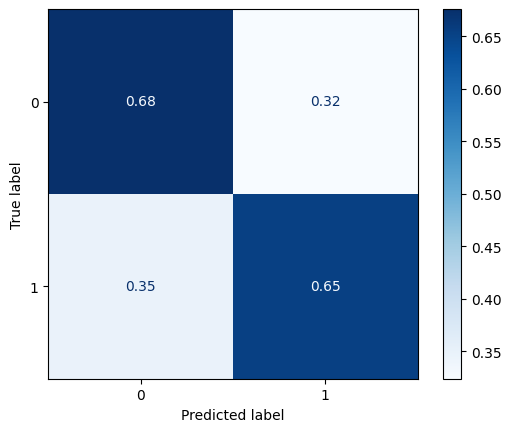

Test Evaluation
              precision    recall  f1-score   support

           0       0.96      0.68      0.79     56554
           1       0.15      0.65      0.24      4949

    accuracy                           0.67     61503
   macro avg       0.55      0.66      0.52     61503
weighted avg       0.89      0.67      0.75     61503



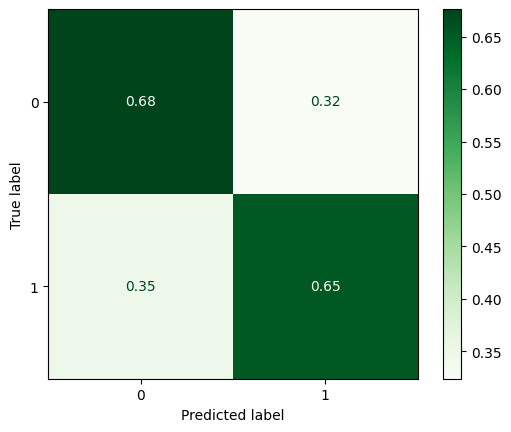

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
LogReg Metrics No Feature Selection,0.674133,0.674455,0.15059,0.150165,0.653653,0.653667,0.244786,0.244225,0.726003,0.725294


In [27]:
# Check metrics between train and val sets

logreg_balc_results = eval_classification(logreg_balc, X_train_proc, y_train, X_val_proc, y_val, model_name = 'LogReg Metrics No Feature Selection')
logreg_balc_results

### Test Data

In [28]:
# Import Test set

test_data = pd.read_csv('test_final.csv')
test_data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START_x,HOUR_APPR_PROCESS_START_x,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,MOST_RECENT,DAYS_CREDIT_REC,MONTHS_BALANCE,STATUS,SK_ID_PREV,PREV_NAME_CONTRACT_TYPE,AMT_APPLICATION,WEEKDAY_APPR_PROCESS_START_y,HOUR_APPR_PROCESS_START_y,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PREV_APP_COUNT,PREV_APP_BINS
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,5896634.0,Active,currency 1,-559.0,0.0,0.0,0.0,Consumer credit,-6.0,26-50,-49.0,0.0,1,1369693.0,Consumer loans,24835.5,FRIDAY,13.0,Y,1.0,XAP,Approved,-1740.0,Cash through the bank,XAP,Refreshed,Mobile,POS,XNA,Country-wide,23.0,Connectivity,high,1.0,0-10
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [29]:
# Kaggle submission requires SK_ID_CURR and prediction columns only, split off SK_ID_CURR column for later merge

id_col = test_data.loc[:,'SK_ID_CURR']
id_col = pd.DataFrame(id_col)

In [30]:
# Transform test data via main pipeline

test_proc = main_pipe.transform(test_data)
test_proc.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_ANNUITY,EXT_SOURCE_2,DAYS_CREDIT,CREDIT_DAY_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,DAYS_CREDIT_REC,MONTHS_BALANCE,AMT_APPLICATION,NFLAG_LAST_APPL_IN_DAY,DAYS_DECISION,SELLERPLACE_AREA,PREV_APP_COUNT,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_nan,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_nan,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_other,CREDIT_TYPE_Business Loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Microloan,CREDIT_TYPE_Real Estate,CREDIT_TYPE_Unknown,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X,CHANNEL_TYPE_AP+ (Cash loan),CHANNEL_TYPE_Car dealer,CHANNEL_TYPE_Channel of corporate sales,CHANNEL_TYPE_Contact center,CHANNEL_TYPE_Country-wide,CHANNEL_TYPE_Credit and cash offices,CHANNEL_TYPE_Regional / Local,CHANNEL_TYPE

### Feature Selection

In [31]:
# Look at removing features by collinearity

# Create threshold to be considered collinear
threshold = .7

# Create selector to classify collinearity

selector = SelectNonCollinear(correlation_threshold=threshold, scoring=f_classif)

# Fit train data to selector

selector.fit(X_train_proc.values, y_train.values)

In [32]:
# Double check length is correct

len(selector.get_support()) - X_train_proc.shape[1]

0

In [48]:
# FIlter to selected rows and make new dataframe

X_train_lowcol = X_train_proc.loc[:, selector.get_support()]
X_val_lowcol = X_val_proc.loc[:, selector.get_support()]

# Check shape for features lost

print(f'All features shape - {X_train_proc.shape}')
print(f'Features selected shape - {X_train_lowcol.shape}')


All features shape - (246008, 283)
Features selected shape - (246008, 242)


In [34]:
# Check columns difference

X_train_proc.columns.difference(X_train_lowcol.columns)

Index(['AMT_ANNUITY', 'CODE_GENDER_F', 'CODE_REJECT_REASON_HC',
       'CODE_REJECT_REASON_XAP', 'CREDIT_ACTIVE_Active',
       'CREDIT_CURRENCY_currency 1', 'CREDIT_TYPE_Consumer credit',
       'DAYS_CREDIT', 'DAYS_CREDIT_UPDATE', 'DAYS_EMPLOYED', 'FLAG_EMP_PHONE',
       'FLAG_LAST_APPL_PER_CONTRACT_Y', 'FLAG_OWN_CAR_N', 'FLAG_OWN_REALTY_Y',
       'LIVE_CITY_NOT_WORK_CITY', 'LIVE_REGION_NOT_WORK_REGION',
       'NAME_CASH_LOAN_PURPOSE_XAP', 'NAME_CASH_LOAN_PURPOSE_XNA',
       'NAME_CLIENT_TYPE_Repeater', 'NAME_CONTRACT_STATUS_Canceled',
       'NAME_CONTRACT_STATUS_Unused offer', 'NAME_CONTRACT_TYPE_Cash loans',
       'NAME_EDUCATION_TYPE_Secondary',
       'NAME_GOODS_CATEGORY_Construction Materials',
       'NAME_GOODS_CATEGORY_Mobile', 'NAME_GOODS_CATEGORY_XNA',
       'NAME_PAYMENT_TYPE_XNA', 'NAME_PORTFOLIO_Cards', 'NAME_PORTFOLIO_Cash',
       'NAME_PORTFOLIO_XNA', 'NAME_PRODUCT_TYPE_XNA',
       'NAME_SELLER_INDUSTRY_Clothing', 'NAME_SELLER_INDUSTRY_Furniture',
       'NAM

In [35]:
# Fit selected columns to model

logreg_sel = LogisticRegression(max_iter=1000, class_weight='balanced')

logreg_sel.fit(X_train_lowcol, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

Train Evaluation
              precision    recall  f1-score   support

           0       0.96      0.68      0.79    226132
           1       0.15      0.65      0.24     19876

    accuracy                           0.67    246008
   macro avg       0.55      0.66      0.52    246008
weighted avg       0.89      0.67      0.75    246008



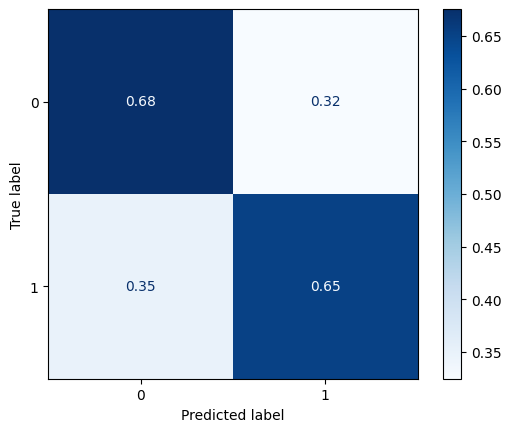

Test Evaluation
              precision    recall  f1-score   support

           0       0.96      0.67      0.79     56554
           1       0.15      0.65      0.24      4949

    accuracy                           0.67     61503
   macro avg       0.55      0.66      0.52     61503
weighted avg       0.89      0.67      0.75     61503



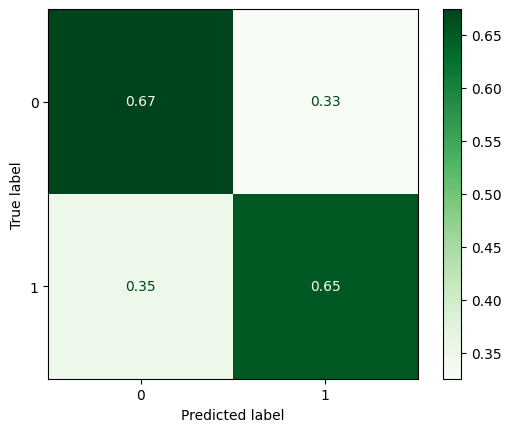

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
LogReg Metrics No Feature Selection,0.674133,0.674455,0.150590,0.150165,0.653653,0.653667,0.244786,0.244225,0.726003,0.725294
LogReg - Features Selected,0.673547,0.672309,0.149966,0.148829,0.651338,0.651041,0.243800,0.242274,0.723659,0.722412


In [36]:
logreg_sel_results = eval_classification(logreg_sel, X_train_lowcol, y_train, X_val_lowcol, y_val, model_name = 'LogReg - Features Selected', results_frame=logreg_balc_results)
logreg_sel_results

In [37]:
# Transform test set

test_proc_lowcol = test_proc.loc[:, selector.get_support()]

In [38]:
# Check shape of test sets

print(f'Test shape - {test_proc.shape}')
print(f'Feature selected Test shape - {test_proc_lowcol.shape}')

Test shape - (48744, 283)
Feature selected Test shape - (48744, 242)


### Predictions and Final Export

In [39]:
# Make predictions

# No feature selection

test_pred = logreg_balc.predict_proba(test_proc)[:,1]
test_pred = pd.DataFrame(test_pred)

# With feature selection

test_pred_sel = logreg_sel.predict_proba(test_proc_lowcol)[:,1]
test_pred_sel = pd.DataFrame(test_pred_sel)

In [40]:
# Combine predictions with ID Column for submission

# No feature selections

logreg_balc_submit = id_col.join(test_pred)
logreg_balc_submit.columns = ['SK_ID_CURR', 'TARGET']

# With feature selection

logreg_sel_submit = id_col.join(test_pred_sel)
logreg_sel_submit.columns = ['SK_ID_CURR', 'TARGET']


In [41]:
# Check formatting is correct with no feature selection

logreg_balc_submit.head()

,SK_ID_CURR,TARGET
0,100001,0.394411
1,100005,0.728105
2,100013,0.269014
3,100028,0.470924
4,100038,0.630377


In [42]:
# Check formatting is correct with feature selection

logreg_sel_submit.head()

,SK_ID_CURR,TARGET
0,100001,0.378122
1,100005,0.755568
2,100013,0.318236
3,100028,0.462390
4,100038,0.644547


In [43]:
# Export to CSV for submission

logreg_balc_submit.to_csv('Data/CreditRisk.csv', index=False)
logreg_sel_submit.to_csv('Data/CreditRisk_Features.csv', index=False)


# Kaggle ROC AUC

## With all features -      0.71175
## With features selected - 0.70936